In [18]:
import logging
import pandas as pd




In [21]:
logging.basicConfig(level=logging.INFO)
RAW_DATA_PATH = "../.data/raw/"
CHUNK_SIZE = 30_000_000
OCT_FILE_PATH = RAW_DATA_PATH + "2019-Oct.csv"

In [25]:
first_chunk = pd.read_csv(OCT_FILE_PATH, nrows=30_000_000)

In [27]:
first_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.0+ GB


In [37]:
first_chunk.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
6,2019-10-01 00:00:08 UTC,view,17300353,2053013553853497655,NaN,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d
7,2019-10-01 00:00:08 UTC,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880
9,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb


In [35]:
first_chunk["price"].describe()

count    3.000000e+07
mean     2.906186e+02
std      3.618333e+02
min      0.000000e+00
25%      6.461000e+01
50%      1.606200e+02
75%      3.585700e+02
max      2.574070e+03
Name: price, dtype: float64

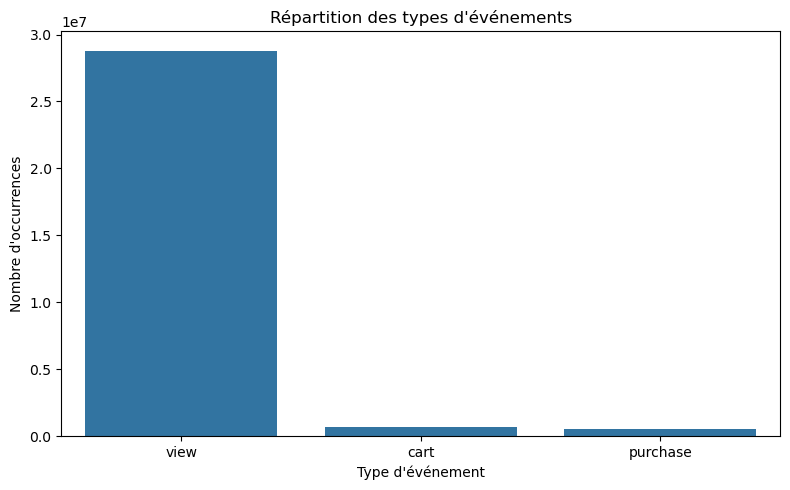

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=first_chunk, x='event_type',
              order=first_chunk['event_type'].value_counts().index)
plt.title('Répartition des types d\'événements')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre d\'occurrences')
plt.tight_layout()
plt.show()

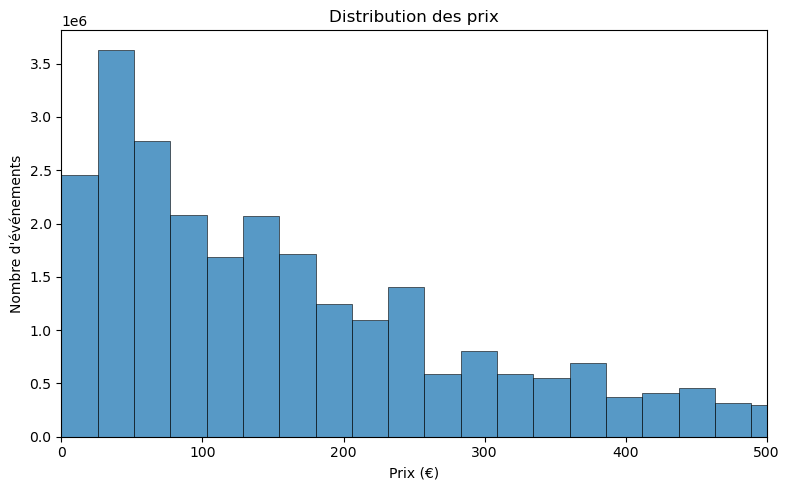

In [30]:
plt.figure(figsize=(8, 5))
sns.histplot(first_chunk['price'], bins=100, kde=False)
plt.title('Distribution des prix')
plt.xlabel('Prix (€)')
plt.ylabel('Nombre d\'événements')
plt.xlim(0, 500)  # Limiter l'axe des X pour éviter les valeurs extrêmes
plt.tight_layout()
plt.show()

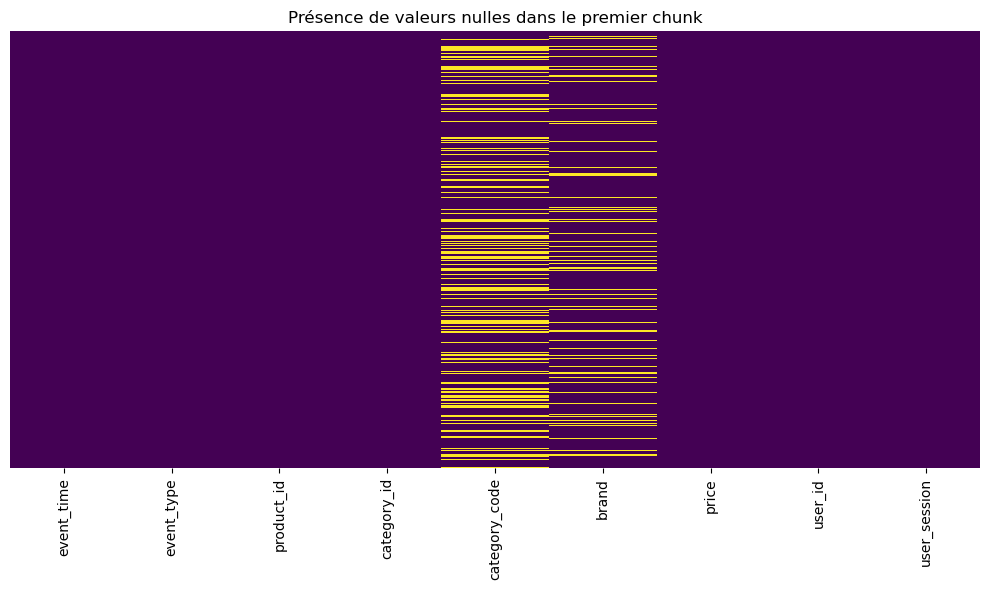

In [31]:
plt.figure(figsize=(10, 6))
sns.heatmap(first_chunk.isnull(), cbar=False,
            yticklabels=False, cmap='viridis')
plt.title('Présence de valeurs nulles dans le premier chunk')
plt.tight_layout()
plt.show()

In [38]:
def clean_chunk(df: pd.DataFrame):
    """DocString"""
    # event_time
    df["event_time"] = pd.to_datetime(
        df["event_time"], utc=True, errors="coerce")
    df = df.dropna(subset=['event_time'])

    # event_type
    valid_events = ["view", "cart", "purchase", "remove_from_cart"]
    df = df[df["event_type"].isin(valid_events)]

    # category_code to main_category and sub_category
    df['category_code'] = df['category_code'].fillna('unknown')
    df['category_code'] = df['category_code'].astype(str)
    df['main_category'] = df['category_code'].apply(
        lambda x: x.split('.')[0] if x != 'unknown' else 'unknown')
    df['sub_category'] = df['category_code'].apply(
        lambda x: 'unknown' if x == 'unknown' else '.'.join(x.split('.')[1:]) or x)

    # user_id
    df = df.dropna(subset=['user_id'])

    # brand
    df["brand"] = df["brand"].fillna("unknown")
    df["brand"] = df["brand"].astype(str)

    # price
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df = df[~((df['event_type'] == 'purchase') & (df['price'].isnull()))]
    df['price'] = df['price'].fillna(0)
    df['price'] = df['price'].astype(float)

    # user_session
    df['user_session'] = df['user_session'].fillna('unknown')
    df['user_session'] = df['user_session'].astype(str)

    # drop columns
    df = df.drop(columns=["category_id", "category_code", "product_id"])

    return df.reset_index(drop=True)

In [39]:
first_chunk_cleaned = clean_chunk(first_chunk)

In [40]:
first_chunk_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 8 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   brand          object             
 3   price          float64            
 4   user_id        int64              
 5   user_session   object             
 6   main_category  object             
 7   sub_category   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 1.8+ GB


In [42]:
first_chunk_cleaned.head(10)

,event_time,event_type,brand,price,user_id,user_session,main_category,sub_category
0,2019-10-01 00:00:00+00:00,view,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,unknown,unknown
1,2019-10-01 00:00:00+00:00,view,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,environment.water_heater
2,2019-10-01 00:00:01+00:00,view,unknown,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,living_room.sofa
3,2019-10-01 00:00:01+00:00,view,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook
4,2019-10-01 00:00:04+00:00,view,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
5,2019-10-01 00:00:05+00:00,view,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,desktop
6,2019-10-01 00:00:08+00:00,view,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d,unknown,unknown
7,2019-10-01 00:00:08+00:00,view,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6,unknown,unknown
8,2019-10-01 00:00:10+00:00,view,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,apparel,shoes.keds
9,2019-10-01 00:00:11+00:00,view,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,electronics,smartphone


In [43]:
print(first_chunk_cleaned.isnull().sum())

event_time       0
event_type       0
brand            0
price            0
user_id          0
user_session     0
main_category    0
sub_category     0
dtype: int64


In [32]:
null_percent = first_chunk.isnull().mean().sort_values(ascending=False) * 100
print(null_percent)

category_code    32.072217
brand            14.062863
user_session      0.000003
event_time        0.000000
event_type        0.000000
category_id       0.000000
product_id        0.000000
price             0.000000
user_id           0.000000
dtype: float64


In [ ]:
df = pd.read_csv(OCT_FILE_PATH)

In [20]:
def load_csv_in_chunks(file_path: str, chunk_size):
    """Docstring"""
    logging.info("Reading file in chunks: %s", file_path)

    for chunk in pd.read_csv(file_path, sep=",", chunksize=chunk_size):
        yield chunk
        break

In [22]:
df_first_chunk = load_csv_in_chunks(OCT_FILE_PATH, CHUNK_SIZE)

In [23]:
df_first_chunk.info()

AttributeError: 'generator' object has no attribute 'info'

In [2]:
import sys
import os
import logging

logging.basicConfig(level=logging.INFO)

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd
from src.data.load_data import load_all_months

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


In [10]:
def clean_chunk(df: pd.DataFrame):
    """DocString"""
    # event_time
    df["event_time"] = pd.to_datetime(
        df["event_time"], utc=True, errors="coerce")
    df = df.dropna(subset=['event_time'])

    # event_type
    valid_events = df["event_type"].unique()
    df = df[df["event_type"].isin(valid_events)]

    # category_code to main_category and sub_category
    df['category_code'] = df['category_code'].fillna('unknown')
    df['category_code'] = df['category_code'].astype(str)
    df['main_category'] = df['category_code'].apply(
        lambda x: x.split('.')[0] if x != 'unknown' else 'unknown')
    df['sub_category'] = df['category_code'].apply(
        lambda x: 'unknown' if x == 'unknown' else '.'.join(x.split('.')[1:]) or x)

    # user_id
    df = df.dropna(subset=['user_id'])

    # brand
    df["brand"] = df["brand"].fillna("unknown")
    df["brand"] = df["brand"].astype(str)

    # price
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['price'] = df['price'].fillna(0)
    df = df[~((df['event_type'] == 'purchase') & (df['price'].isnull()))]
    df['price'] = df['price'].astype(float)

    # user_session
    df['user_session'] = df['user_session'].fillna('unknown')
    df['user_session'] = df['user_session'].astype(str)

    # drop columns
    df = df.drop(columns=["category_id", "category_code", "product_id"])

    return df.reset_index(drop=True)

In [ ]:
data_raw_path = "../.data/raw"
data_interim_path = "../.data/interim"
CHUNK_SIZE = 30_000_000

chunks = load_all_months(data_raw_path, chunck_size=CHUNK_SIZE)


for i, chunk in enumerate(chunks):
    logging.info("Start cleaning chunk_%s",i)
    df_clean = clean_chunk(chunk)
    logging.info("chunk_%s cleaned successfully.",i)
    df_clean.to_parquet(
        f"{data_interim_path}/cleaned_chunk_{i}.parquet", index=False)
    logging.info("cleaned_chunk_%s extracted successfully to %s/cleaned_chunk_%s.parquet.", i, data_interim_path, i)

logging.info("All operations are successfully processed.")

In [3]:
from src.data.load_data import load_all_parquet
df = load_all_parquet("../.data/interim")



INFO:root:Found 17 .parquet files in ../.data/interim
INFO:root:Loading: ../.data/interim\cleaned_chunk_0.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_1.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_10.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_11.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_12.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_13.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_14.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_15.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_16.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_2.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_3.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_4.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_5.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_6.parquet
INFO:root:Loading: ../.data/interim\cleaned_chunk_7.parquet
INFO:root:Loading: ../.data/interim\cle

In [5]:
df.head(15)

,event_time,event_type,brand,price,user_id,user_session,main_category,sub_category
0,2019-12-01 00:00:00+00:00,view,apple,1302.48,556695836,ca5eefc5-11f9-450c-91ed-380285a0bc80,construction,tools.light
1,2019-12-01 00:00:00+00:00,view,force,102.96,577702456,de33debe-c7bf-44e8-8a12-3bf8421f842a,unknown,unknown
2,2019-12-01 00:00:01+00:00,view,bosch,313.52,539453785,5ee185a7-0689-4a33-923d-ba0130929a76,appliances,personal.massager
3,2019-12-01 00:00:02+00:00,purchase,unknown,132.31,535135317,61792a26-672f-4e61-9832-7b63bb1714db,computers,peripherals.printer
4,2019-12-01 00:00:02+00:00,view,nika,101.68,517987650,906c6ca8-ff5c-419a-bde9-967ba8e2233e,apparel,trousers
5,2019-12-01 00:00:02+00:00,view,ikea,163.56,542860793,a1bcb550-1065-4769-a80a-0ccb4bcee78d,accessories,umbrella
6,2019-12-01 00:00:02+00:00,view,unknown,88.81,538021416,e88f77cc-e75e-4e9f-9ef6-ef1a302ed50a,electronics,clocks
7,2019-12-01 00:00:03+00:00,view,xiaomi,256.38,525740700,370e8c88-3d07-41df-9aaa-2adf5a0bf312,construction,tools.light
8,2019-12-01 00:00:04+00:00,view,jet,20.57,512509221,4227259f-1c4c-41dc-84b5-9354d864eefa,computers,notebook
9,2019-12-01 00:00:04+00:00,view,unknown,179.16,553345124,58c692ff-c7a9-4e35-9ec4-58598f1940e0,construction,components.faucet


In [ ]:
df["event_type"].unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [20]:
df.describe()

,price,user_id
count,4.117097e+08,4.117097e+08
mean,2.854616e+02,5.569677e+08
std,3.568473e+02,3.877903e+07
min,0.000000e+00,1.030022e+07
25%,6.201000e+01,5.193236e+08
50%,1.616500e+02,5.510967e+08
75%,3.500500e+02,5.854228e+08
max,2.574070e+03,6.497760e+08
